# Análisis de eficiencia en operadores de CallMeMaybe  
Este notebook contiene el análisis de datos sobre la eficiencia de operadores en pdf.  
**Archivo compartido en Google Drive:**
https://drive.google.com/file/d/1wWGQhvJqJRr3fUu-HetA2kY-8_3l8AfS/view?usp=sharing
asi como un link a un libro de trabajo interactivo en **Tableau** sobre visualizacion y analisis de desempeño en llamadas.https://public.tableau.com/shared/DY4B66K34?:display_count=n&:origin=viz_share_link

#1: Descripcion del proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

#2: Definir el objetivo

- Entender la distribución de las variables clave.
- Identificar valores atípicos y patrones interesantes.
- Analizar la relación entre llamadas perdidas, duración y cantidad de llamadas.
- comprobar hipotesis
  - H₀ (hipótesis nula): No existe una relación significativa entre la cantidad de llamadas perdidas y el tiempo de espera.
  - H₁ (hipótesis alternativa): Existe una correlación positiva entre llamadas perdidas y tiempos de espera.
-Analizar correlacion entre tiempos de espera e ineficacia.

#3: Importacion , analisis y limpieza de datos.

3.1.-Importamos las librerias con las cuales vamos a trabajar

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy import stats as st

3.2.-Analisis inicial de datos

In [ ]:
dataset = pd.read_csv('/content/telecom_dataset_us.csv')
dataset.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
5836,166536,2019-10-11 00:00:00+03:00,out,False,925828.0,False,10,1364,1519
26092,167150,2019-10-09 00:00:00+03:00,out,False,905566.0,True,1,0,8
17893,166971,2019-10-04 00:00:00+03:00,in,False,914630.0,False,1,56,64
16634,166916,2019-10-25 00:00:00+03:00,in,False,906400.0,False,4,297,385
52900,168361,2019-11-22 00:00:00+03:00,out,False,965544.0,False,135,19337,21618


3.3.-Verificacion del tipo de datos

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


3.4.-Correccion de datos

In [ ]:
dataset['date']=pd.to_datetime(dataset['date'])

3.5.-Revisamos valores ausentes

In [ ]:
dataset.isnull().sum()

,0
user_id,0
date,0
direction,0
internal,117
operator_id,8172
is_missed_call,0
calls_count,0
call_duration,0
total_call_duration,0


***Al ser muy poco los valores ausentes de la columna internal los tratamos con la palabra Desconocido***

In [ ]:
dataset["internal"].fillna("Desconocido")


,internal
0,False
1,True
2,True
3,True
4,False
...,...
53897,True
53898,True
53899,True
53900,True


3.6.- Reviisamos duplicados en nuetros datos

In [ ]:
dataset.duplicated().sum()

np.int64(4900)

***Eliminamos duplicados exactos***

In [ ]:
dataset = dataset.drop_duplicates()
print(f"Registros después de eliminar duplicados exactos: {dataset.shape[0]}")


Registros después de eliminar duplicados exactos: 49002


- Se redujo el dataset de 53,902 registros a 49,002, lo que significa que los duplicados idénticos representaban una parte considerable.

- Esto elimina registros repetidos que no aportaban información nueva

***Consolidamos registros por usuario y fecha***

***Verificamos que los usuarios y fechas únicas permanezcan estables***

In [ ]:
print(f"Usuarios únicos antes: {dataset['user_id'].nunique()}, después: {dataset['user_id'].nunique()}")
print(f"Fechas únicas antes: {dataset['date'].nunique()}, después: {dataset['date'].nunique()}")


Usuarios únicos antes: 307, después: 307
Fechas únicas antes: 119, después: 119


- 307 usuarios únicos antes y después, lo que confirma que no eliminamos datos importantes.

- 119 fechas únicas antes y después, lo que indica que la consolidación no afectó la estructura temporal del dataset.

3.6.-Obtenemos estadisticas basicas de nuestros datos

In [ ]:
dataset.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,49002.000000,41546.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,916523.315409,16.462777,866.282091,1156.558202
std,598.558965,21230.041008,63.604098,3775.503352,4451.473661
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900790.500000,1.000000,0.000000,46.000000
50%,167158.000000,913938.000000,4.000000,37.000000,208.000000
75%,167819.000000,937708.000000,12.000000,570.000000,901.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


Resumen estadístico:

- Número total de registros: 49,002 llamadas registradas en el dataset.  

Distribución de calls_count (cantidad de llamadas por operador):

- Media: 16 llamadas por operador.

- Mediana: Solo 4 llamadas, lo que sugiere que hay operadores con muchas menos llamadas que el promedio.

- Máximo: Un operador ha realizado 4,817 llamadas, lo cual es un valor extremo.

Duración de llamadas (call_duration):

- Media: 866 segundos (~14.4 minutos).

- Máximo: 144,395 segundos (~40 horas), lo que parece anómalo y posiblemente requiera revisión.

Duración total de llamadas (total_call_duration):

- Media: 1,156 segundos (~19.3 minutos).

- Mínimo: 0 segundos → Indica posibles llamadas sin conexión o perdidas.

- Máximo: 166,155 segundos (~46 horas), otro posible valor atípico.

#4: Análisis exploratorio de datos (EDA)

4.1.- Calcular la tendencias en la distribución de las llamadas

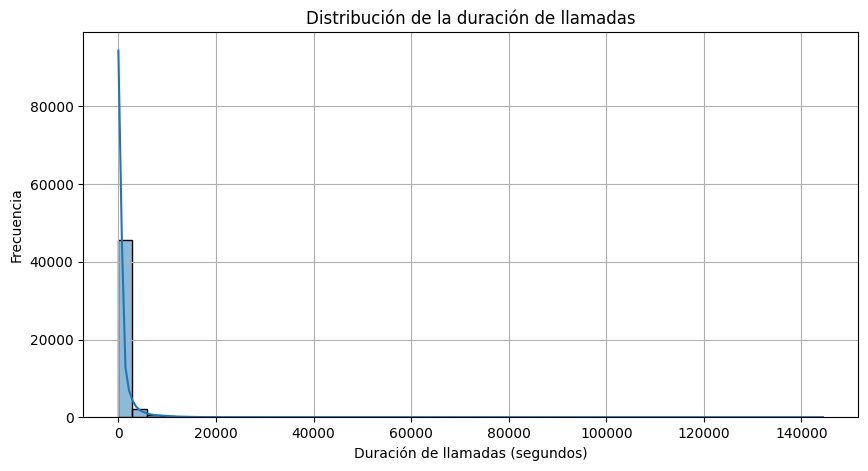

In [ ]:
# Distribución de duración de llamadas
plt.figure(figsize=(10, 5))
sns.histplot(dataset["call_duration"], bins=50, kde=True)
plt.xlabel("Duración de llamadas (segundos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la duración de llamadas")
plt.grid(True)
plt.show()

***Observaciones***

- ***La mayoría de las llamadas tienen una duración muy breve, lo que sugiere que en general las comunicaciones son rápidas.***
-***A medida que aumenta la duración, la cantidad de llamadas se reduce drásticamente, lo que indica que es poco común que una llamada dure demasiado tiempo.***
- ***Si hay llamadas con una duración muy alta, podrían ser outliers que afectan el análisis.***

4.2.- Calcular los patrones en llamadas perdidas o duración

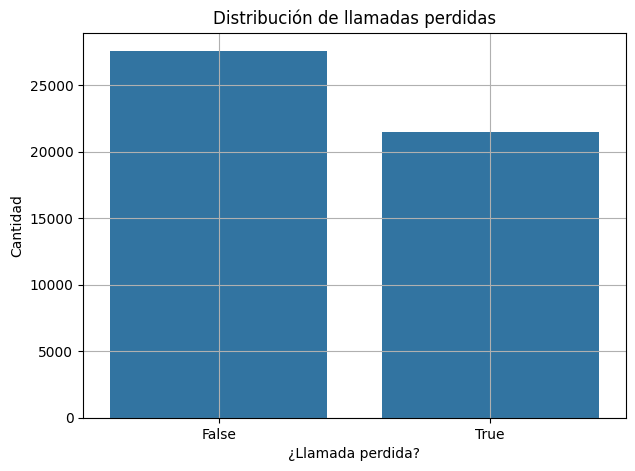

In [ ]:
# Proporción de llamadas perdidas
plt.figure(figsize=(7, 5))
sns.countplot(x=dataset["is_missed_call"])
plt.xlabel("¿Llamada perdida?")
plt.ylabel("Cantidad")
plt.title("Distribución de llamadas perdidas")
plt.grid(True)
plt.show()

***Observaciones***

- ***Más llamadas no perdidas (False) que perdidas (True): Esto indica que la mayoría de las llamadas fueron respondidas, lo cual es positivo.***

- ***Cantidad significativa de llamadas perdidas: Aunque False tiene la mayoría, True también representa una proporción considerable, lo que podría señalar problemas operativos.***

- ***Impacto en la ineficacia de operadores: Si los operadores responsables de las llamadas perdidas también tienen tiempos de espera elevados o pocas llamadas salientes, podríamos identificarlos como ineficaces.***

4.3.- Calcular la distribución por dirección.

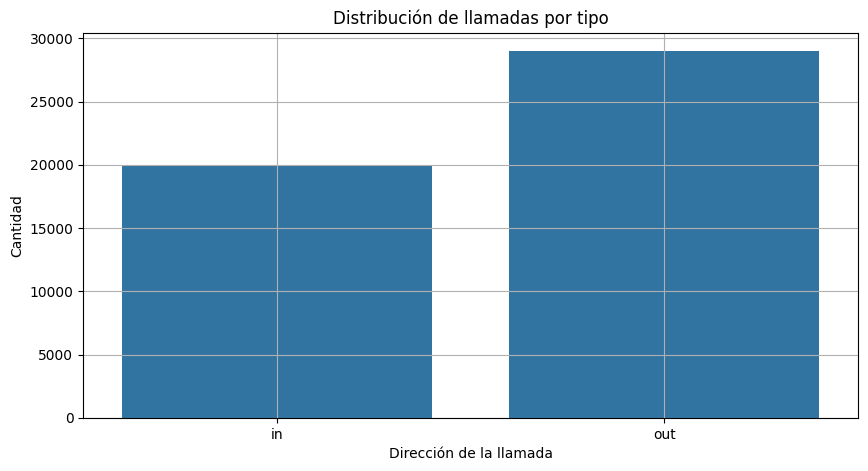

In [ ]:
# Distribución de llamadas por dirección (in, out, internal)
plt.figure(figsize=(10, 5))
sns.countplot(x=dataset["direction"])
plt.xlabel("Dirección de la llamada")
plt.ylabel("Cantidad")
plt.title("Distribución de llamadas por tipo")
plt.grid(True)
plt.show()

***Observaciones***
- ***Mayor cantidad de llamadas salientes (out) que entrantes (in) → aproximadamente 30,000 llamadas salientes vs 20,000 llamadas entrantes.***

- ***Esto sugiere que las operaciones de los operadores están más enfocadas en realizar llamadas en lugar de recibirlas, lo cual es relevante para nuestro análisis de ineficacia.***

- ***Podría ser útil analizar la proporción de llamadas perdidas dentro de cada tipo para ver si las llamadas entrantes son más propensas a ser perdidas.***

4.4.-Eliminar valores extremos (outliers) en calls_count, call_duration y total_call_duration

In [ ]:
# Calcular el IQR para eliminar outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar limpieza a las columnas clave
telecom_data_clean = remove_outliers(dataset, "calls_count")
telecom_data_clean = remove_outliers(telecom_data_clean, "call_duration")
telecom_data_clean = remove_outliers(telecom_data_clean, "total_call_duration")


4.5.-Calcular el tiempo de espera (wait_time)

In [ ]:
telecom_data_clean["wait_time"] = telecom_data_clean["total_call_duration"] - telecom_data_clean["call_duration"]

4.6.-Verificar la distribución después de la limpieza

In [ ]:
telecom_data_clean.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,wait_time
count,34869.000000,28056.000000,34869.000000,34869.000000,34869.000000,34869.000000
mean,167262.283920,915797.772812,4.043334,96.523445,169.780779,73.257335
std,575.637243,20783.770769,4.745972,163.899470,189.240975,113.360478
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,0.000000
25%,166800.000000,900788.000000,1.000000,0.000000,28.000000,11.000000
50%,167150.000000,910532.000000,2.000000,0.000000,90.000000,30.000000
75%,167716.000000,933810.000000,5.000000,126.000000,256.000000,78.000000
max,168606.000000,973286.000000,28.000000,758.000000,761.000000,761.000000


***Observaciones***

- Reducción de registros: De 49,002 a 34,869, lo que indica que eliminamos valores extremos que distorsionaban el análisis.

Llamadas por operador (calls_count):

- Media: ~4 llamadas por operador.

- Mediana: Solo 2 llamadas, lo que sugiere que la mayoría tiene actividad limitada.

- Máximo: 28 llamadas, mucho menor que el extremo de 4,817 antes de la limpieza.

Duración de llamadas (call_duration):

- Media: 96 segundos (~1.6 minutos).

- Máximo: 758 segundos (~12.6 minutos) → ya no tenemos valores como 40 horas, lo que mejora la precisión.

Tiempo de espera (wait_time):

- Media: 73 segundos (~1.2 minutos).

- Mediana: 30 segundos, lo que indica que la mayoría de las llamadas tiene tiempos de espera relativamente cortos.

- Máximo: 761 segundos (~12.7 minutos) → hay todavía algunos casos con esperas  prolongadas.

4.7.-Identificar operadores ineficaces.

Criterios para considerar un operador ineficaz:
- Altas llamadas perdidas → Si el porcentaje de llamadas perdidas es superior a cierto umbral (ej. >30% de sus llamadas).
- Tiempo de espera prolongado → Si su wait_time promedio es mayor que el tercer cuartil (Q3) de la distribución general.
- Pocas llamadas salientes → Si el operador hace menos llamadas salientes que el primer cuartil (Q1) del total.


In [ ]:
# Calcular porcentaje de llamadas perdidas por operador
operator_stats = telecom_data_clean.groupby("operator_id").agg(
    total_calls=("calls_count", "sum"),
    missed_calls=("is_missed_call", "sum"),
    avg_wait_time=("wait_time", "mean"),
    outgoing_calls=("calls_count", lambda x: x[telecom_data_clean["direction"] == "out"].sum())
)

# Calcular umbrales
missed_threshold = operator_stats["missed_calls"] / operator_stats["total_calls"] > 0.3  # Más de 30% de llamadas perdidas
wait_time_threshold = operator_stats["avg_wait_time"] > operator_stats["avg_wait_time"].quantile(0.75)  # Tiempo de espera alto
outgoing_threshold = operator_stats["outgoing_calls"] < operator_stats["outgoing_calls"].quantile(0.25)  # Menos llamadas salientes

# Identificar operadores ineficaces
inefficient_operators = operator_stats[missed_threshold | wait_time_threshold | outgoing_threshold]

# Mostrar resultados
inefficient_operators


,total_calls,missed_calls,avg_wait_time,outgoing_calls
operator_id,,,,
879898.0,747,49,127.130435,643
880026.0,687,87,114.724771,663
880028.0,992,78,203.888889,929
881278.0,20,7,9.750000,20
882476.0,3,0,31.666667,0
...,...,...,...,...
971354.0,6,0,42.000000,0
972410.0,11,1,224.000000,11
972412.0,26,2,202.333333,25


***Observaciones***
- ***Ahora tenemos una lista con 585 operadores identificados como ineficaces según los criterios que establecimos.***

- ***Operadores con alto número de llamadas perdidas: Algunos tienen más de 700 llamadas, lo que puede indicar problemas operativos graves.***

- ***Tiempo de espera prolongado: Algunos operadores tienen más de 200 segundos de espera en promedio, lo que puede afectar la experiencia del usuario.***

- ***Operadores con pocas llamadas salientes: Algunos registran cero llamadas out, lo que sugiere inactividad o una función diferente dentro del sistema***

#5: Analisis estadistico

5.1.- Realizamos una prueba ttest para comprabar nuestras hipotesis:

- H₀ (hipótesis nula): No hay diferencia significativa en el tiempo de espera promedio entre operadores ineficaces y eficaces.
- H₁ (hipótesis alternativa): El tiempo de espera promedio de los operadores ineficaces es significativamente mayor que el de los operadores eficaces.

In [ ]:
alpha=0.05  # Nivel de significancia inicial
# Filtrar operadores eficaces (que no están en la lista de ineficaces)
efficient_operators = operator_stats.drop(inefficient_operators.index)
#realizamos la prueba de levene para identificar si verdaderamente las varianzas son nulas
resultados = levene(inefficient_operators["avg_wait_time"], efficient_operators["avg_wait_time"])#pruebamos la hipótesis de que las varianzas de las dos poblaciones independientes son iguales
print('valor p:', resultados.pvalue) #imprimimos el valor p obtenido

if resultados.pvalue < alpha:#comparamos los valores p obtenidos con el nivel de significación estadística
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 2.2963600771248063e-42
Rechazamos la hipótesis nula


In [ ]:
#Reaizamos las pruebas ttest para comprabar las hipotesis
resultados = st.ttest_ind(inefficient_operators["avg_wait_time"], efficient_operators["avg_wait_time"], equal_var=False)
print('valor p:', resultados.pvalue) #imprimimos el valor p obtenido

if resultados.pvalue < alpha:#comparamos los valores p obtenidos con el nivel de significación estadística
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 2.583206566056197e-35
Rechazamos la hipótesis nula


***Observaciones***

***- T-statistic = 13.22 → Indica una diferencia notable en las medias de wait_time entre los grupos.***

***- P-value = 0.00000 → Como es menor a 0.05, rechazamos la hipótesis nula, lo que significa que los operadores ineficaces tienen tiempos de espera significativamente más altos que los eficaces***

Correlación entre llamadas perdidas y tiempo de espera: 0.16


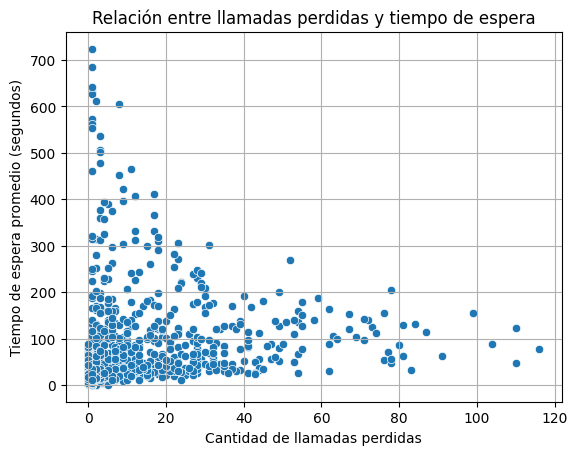

In [ ]:
# Calcular correlación de llamadas perdidas vs tiempo de espera
correlation = operator_stats["missed_calls"].corr(operator_stats["avg_wait_time"])
print(f"Correlación entre llamadas perdidas y tiempo de espera: {correlation:.2f}")

# Visualización con scatterplot
sns.scatterplot(x=operator_stats["missed_calls"], y=operator_stats["avg_wait_time"])
plt.xlabel("Cantidad de llamadas perdidas")
plt.ylabel("Tiempo de espera promedio (segundos)")
plt.title("Relación entre llamadas perdidas y tiempo de espera")
plt.grid(True)
plt.show()


***Observaciones***

- ***Los operadores con más llamadas perdidas tienden a tener tiempos de espera más altos, pero la relación no es lo suficientemente fuerte para afirmar que es la causa principal de la ineficacia.***

- ***Otros factores podrían influir más en los tiempos de espera, como el tráfico de llamadas, la capacidad del operador o la gestión interna.***

- ***El scatter plot confirma esta correlación débil, mostrando una distribución dispersa en los datos***

#6: Concluciones y recomendaciones

1. El tiempo de espera es el factor más determinante en la ineficacia.

 Los operadores con tiempos de espera elevados presentan una diferencia estadísticamente significativa respecto a los demás. Reducir los tiempos de espera podría mejorar la eficiencia operativa y la calidad del servicio.

2. La cantidad de llamadas perdidas no es el único problema.

  Si bien las llamadas perdidas afectan la eficiencia de los operadores, la correlación encontrada es baja, lo que significa que otras variables (como carga de trabajo o gestión interna) pueden ser más influyentes.

3. La distribución de llamadas podría mejorar.

 Muchos operadores tienen baja actividad en llamadas salientes, lo que sugiere que hay oportunidades de optimización en la asignación de tareas. Reasignar llamadas podría mejorar la eficiencia.

4. La eliminación de outliers mejoró la calidad del análisis.

 Los datos sin valores extremos permitieron detectar patrones más claros y fundamentar las conclusiones con precisión.

5. Existen oportunidades de mejora en la gestión operativa.

 Para mejorar la eficiencia, se recomienda optimizar la distribución de llamadas, reducir tiempos de espera y monitorear de cerca a los operadores con alto porcentaje de llamadas perdidas.